In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
doge_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "doge"]

In [7]:
doge_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
5213,doge,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214
5214,doge,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215
5215,doge,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216
5216,doge,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217
5217,doge,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [8]:
end_date = doge_price['date'].iloc[-1]
end_date

'2022-07-13'

In [9]:
doge_price['date'] = pd.to_datetime(doge_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
doge_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
doge_price.set_index("date",inplace = True)

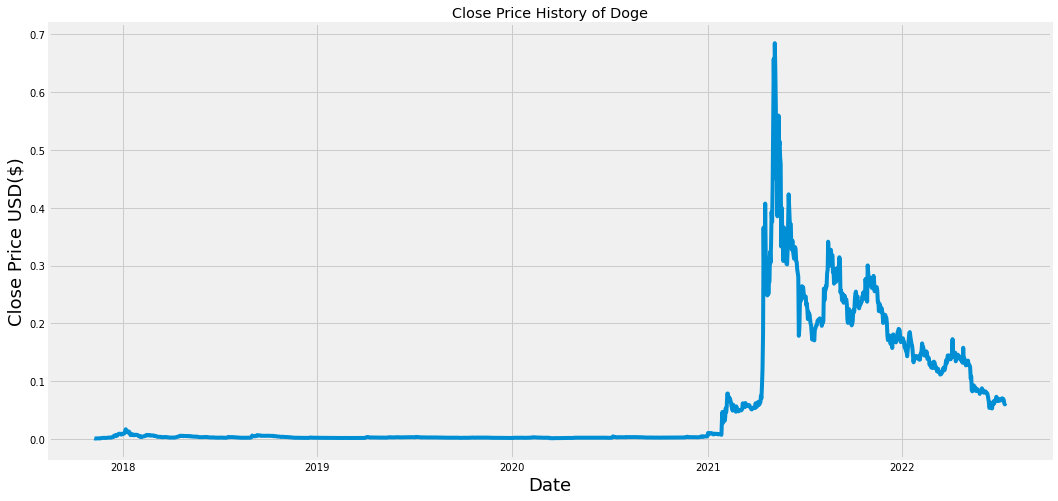

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Doge')
plt.plot(doge_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = doge_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((1367, 1), (341, 1))

In [17]:
train

,close
date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211
...,...
2021-08-02,0.203600
2021-08-03,0.195967
2021-08-04,0.201490


In [18]:
test

,close
date,
2021-08-07,0.260341
2021-08-08,0.240045
2021-08-09,0.256897
2021-08-10,0.257325
2021-08-11,0.265263
...,...
2022-07-09,0.069512
2022-07-10,0.067263
2022-07-11,0.061847


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.00055138],
       [0.00018282],
       [0.0002384 ],
       ...,
       [0.08893598],
       [0.0863619 ],
       [0.08909101]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(1366, 1367)

In [21]:
train_scaled.shape,test_scaled.shape

((1367, 1), (341, 1))

In [22]:
train_scaled

array([[5.51379986e-04],
       [1.82818298e-04],
       [2.38395060e-04],
       ...,
       [2.93170347e-01],
       [2.92415673e-01],
       [2.97847570e-01]])

In [23]:
test_scaled

array([[0.37924266],
       [0.34955882],
       [0.37420565],
       [0.37483162],
       [0.38644132],
       [0.38447858],
       [0.41795188],
       [0.42717323],
       [0.49785518],
       [0.46754244],
       [0.43642969],
       [0.44271425],
       [0.46231969],
       [0.47745265],
       [0.46181218],
       [0.45912987],
       [0.46344585],
       [0.42077606],
       [0.42587596],
       [0.39177376],
       [0.4291038 ],
       [0.41622754],
       [0.40964023],
       [0.39647731],
       [0.4057323 ],
       [0.42905699],
       [0.43132979],
       [0.43179488],
       [0.43635071],
       [0.4584922 ],
       [0.45006501],
       [0.36959425],
       [0.37452156],
       [0.36791524],
       [0.34946668],
       [0.35158737],
       [0.36502086],
       [0.34350534],
       [0.35052995],
       [0.36075023],
       [0.35322981],
       [0.34939063],
       [0.3515201 ],
       [0.33946287],
       [0.30133282],
       [0.29249319],
       [0.32734713],
       [0.327

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 160
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(1206, 160)
(1206,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(180, 160)
(180,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
print(X_train.shape), print(y_train.shape)

(1206, 160, 1)
(1206,)


(None, None)

In [30]:
print(X_test.shape), print(ytest.shape)

(180, 160, 1)
(180,)


(None, None)

In [31]:
X_test

array([[[0.37924266],
        [0.34955882],
        [0.37420565],
        ...,
        [0.22283503],
        [0.23490542],
        [0.25010274]],

       [[0.34955882],
        [0.37420565],
        [0.37483162],
        ...,
        [0.23490542],
        [0.25010274],
        [0.2669308 ]],

       [[0.37420565],
        [0.37483162],
        [0.38644132],
        ...,
        [0.25010274],
        [0.2669308 ],
        [0.2692036 ]],

       ...,

       [[0.20587827],
        [0.20708633],
        [0.19919443],
        ...,
        [0.10176836],
        [0.09977345],
        [0.1001464 ]],

       [[0.20708633],
        [0.19919443],
        [0.19964197],
        ...,
        [0.09977345],
        [0.1001464 ],
        [0.09685713]],

       [[0.19919443],
        [0.19964197],
        [0.21421186],
        ...,
        [0.1001464 ],
        [0.09685713],
        [0.08893598]]])

In [32]:
ytest

array([0.2669308 , 0.2692036 , 0.25760999, 0.24878938, 0.24051136,
       0.23593506, 0.22547493, 0.20709949, 0.19284259, 0.20596309,
       0.20001784, 0.20769767, 0.20877996, 0.20506217, 0.20566035,
       0.20770791, 0.20246468, 0.20587827, 0.20708633, 0.19919443,
       0.19964197, 0.21421186, 0.21368241, 0.22337763, 0.24064738,
       0.23015654, 0.23120664, 0.22062658, 0.21032733, 0.20968089,
       0.21632524, 0.21201804, 0.22043938, 0.21654023, 0.2011206 ,
       0.20143651, 0.2050022 , 0.19865767, 0.18640446, 0.19088424,
       0.18546258, 0.17956413, 0.18506769, 0.18517153, 0.17853742,
       0.1932287 , 0.19437241, 0.19298592, 0.18804251, 0.1777769 ,
       0.18129432, 0.17510775, 0.16975337, 0.16964222, 0.17630997,
       0.16943161, 0.16755516, 0.16687362, 0.16171375, 0.16528237,
       0.16343371, 0.16946525, 0.16887146, 0.17297244, 0.17920727,
       0.17275013, 0.1730207 , 0.17761602, 0.18821363, 0.19819259,
       0.19009447, 0.19719513, 0.21015914, 0.20712436, 0.20977

In [33]:
np.random.seed(42)
tf.random.set_seed(42)
window_len = 160
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [34]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
38/38 [==============================] - 15s 181ms/step - loss: 0.0054
Epoch 2/100
38/38 [==============================] - 7s 181ms/step - loss: 0.0024
Epoch 3/100
38/38 [==============================] - 7s 171ms/step - loss: 0.0020
Epoch 4/100
38/38 [==============================] - 7s 183ms/step - loss: 0.0018
Epoch 5/100
38/38 [==============================] - 7s 189ms/step - loss: 0.0016
Epoch 6/100
38/38 [==============================] - 7s 184ms/step - loss: 0.0019
Epoch 7/100
38/38 [==============================] - 7s 182ms/step - loss: 0.0015
Epoch 8/100
38/38 [==============================] - 7s 192ms/step - loss: 0.0015
Epoch 9/100
38/38 [==============================] - 7s 184ms/step - loss: 0.0013
Epoch 10/100
38/38 [==============================] - 7s 195ms/step - loss: 0.0014
Epoch 11/100
38/38 [==============================] - 7s 189ms/step - loss: 0.0012
Epoch 12/100
38/38 [==============================] - 7s 187ms/step - loss: 0.0012
Epoch 13/100

Epoch 96/100
38/38 [==============================] - 7s 173ms/step - loss: 3.6035e-04
Epoch 97/100
38/38 [==============================] - 6s 169ms/step - loss: 3.2541e-04
Epoch 98/100
38/38 [==============================] - 7s 186ms/step - loss: 3.0699e-04
Epoch 99/100
38/38 [==============================] - 7s 192ms/step - loss: 4.0343e-04
Epoch 100/100
38/38 [==============================] - 7s 193ms/step - loss: 3.1171e-04


In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 61ms/step


In [38]:
test_predict

array([[0.2779427 ],
       [0.2983982 ],
       [0.3121227 ],
       [0.30974886],
       [0.29508597],
       [0.277018  ],
       [0.2634401 ],
       [0.25365528],
       [0.24150689],
       [0.22577795],
       [0.21852008],
       [0.21600334],
       [0.21913452],
       [0.2241678 ],
       [0.22638023],
       [0.22646685],
       [0.22699991],
       [0.22641252],
       [0.22762783],
       [0.23077658],
       [0.23087329],
       [0.22936672],
       [0.23392928],
       [0.24013212],
       [0.24811515],
       [0.2607088 ],
       [0.2656116 ],
       [0.26331392],
       [0.25333259],
       [0.23898324],
       [0.22812614],
       [0.2266443 ],
       [0.2290949 ],
       [0.23542562],
       [0.23936437],
       [0.23338152],
       [0.22434421],
       [0.21981749],
       [0.21809314],
       [0.2139692 ],
       [0.2122233 ],
       [0.21113104],
       [0.20870678],
       [0.2090118 ],
       [0.21137156],
       [0.2113222 ],
       [0.21590126],
       [0.222

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.016158946319151882

In [40]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.025250339420252465

In [41]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.022017661125729813

In [42]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.13316362047267885

In [43]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)

13.32


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
test_predict

array([[0.19107826],
       [0.20506449],
       [0.21444847],
       [0.21282537],
       [0.20279978],
       [0.19044602],
       [0.18116228],
       [0.17447202],
       [0.16616568],
       [0.1554112 ],
       [0.15044871],
       [0.14872791],
       [0.15086882],
       [0.15431027],
       [0.15582299],
       [0.15588222],
       [0.15624669],
       [0.15584508],
       [0.15667602],
       [0.15882896],
       [0.15889508],
       [0.15786497],
       [0.16098458],
       [0.1652257 ],
       [0.17068401],
       [0.17929478],
       [0.182647  ],
       [0.181076  ],
       [0.17425138],
       [0.16444017],
       [0.15701674],
       [0.15600355],
       [0.15767911],
       [0.16200769],
       [0.16470076],
       [0.16061005],
       [0.1544309 ],
       [0.15133579],
       [0.1501568 ],
       [0.1473371 ],
       [0.14614336],
       [0.14539653],
       [0.14373897],
       [0.14394751],
       [0.14556098],
       [0.14552724],
       [0.14865811],
       [0.153

In [46]:
test_predict.shape

(180, 1)

In [47]:
targets = test[price_column][window_len+1:]
targets

date
2022-01-15    0.185103
2022-01-16    0.177176
2022-01-17    0.171145
2022-01-18    0.165485
2022-01-19    0.162356
                ...   
2022-07-09    0.069512
2022-07-10    0.067263
2022-07-11    0.061847
2022-07-12    0.060087
2022-07-13    0.061953
Name: close, Length: 180, dtype: float64

In [48]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2022-01-15    0.191078
2022-01-16    0.205064
2022-01-17    0.214448
2022-01-18    0.212825
2022-01-19    0.202800
                ...   
2022-07-09    0.074074
2022-07-10    0.074578
2022-07-11    0.074903
2022-07-12    0.074338
2022-07-13    0.071521
Length: 180, dtype: float32

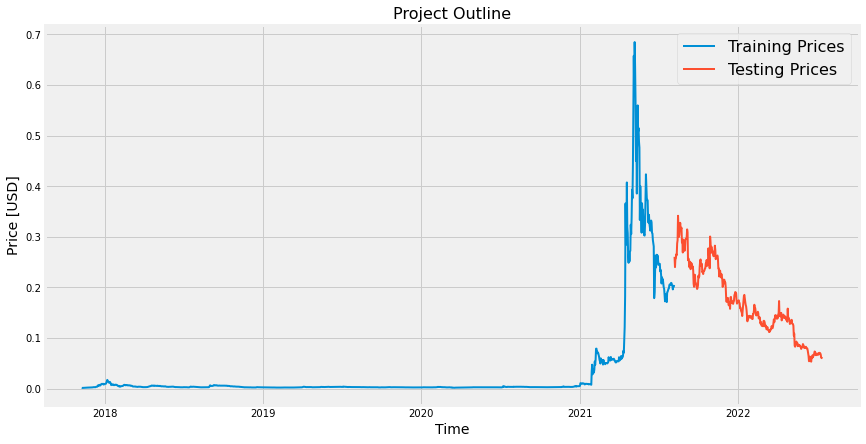

In [49]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

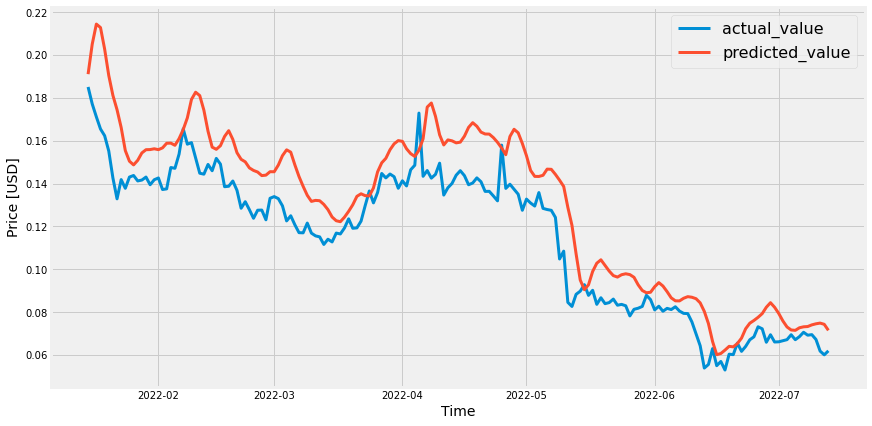

In [50]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [51]:
len(test)

341

In [52]:
length = len(test_scaled)
length

341

In [53]:
#Getting the last 100 days records
fut_inp = test_scaled[length-160:]
fut_inp.shape

(160, 1)

In [54]:
fut_inp = fut_inp.reshape(1,-1)

In [55]:
fut_inp.shape

(1, 160)

In [56]:
fut_inp

array([[0.21421186, 0.21368241, 0.22337763, 0.24064738, 0.23015654,
        0.23120664, 0.22062658, 0.21032733, 0.20968089, 0.21632524,
        0.21201804, 0.22043938, 0.21654023, 0.2011206 , 0.20143651,
        0.2050022 , 0.19865767, 0.18640446, 0.19088424, 0.18546258,
        0.17956413, 0.18506769, 0.18517153, 0.17853742, 0.1932287 ,
        0.19437241, 0.19298592, 0.18804251, 0.1777769 , 0.18129432,
        0.17510775, 0.16975337, 0.16964222, 0.17630997, 0.16943161,
        0.16755516, 0.16687362, 0.16171375, 0.16528237, 0.16343371,
        0.16946525, 0.16887146, 0.17297244, 0.17920727, 0.17275013,
        0.1730207 , 0.17761602, 0.18821363, 0.19819259, 0.19009447,
        0.19719513, 0.21015914, 0.20712436, 0.20977595, 0.20793314,
        0.20005879, 0.20516162, 0.20164858, 0.21267618, 0.21580311,
        0.25136638, 0.20823589, 0.21216283, 0.2069664 , 0.20953171,
        0.21718375, 0.1954196 , 0.20042443, 0.20335537, 0.20897155,
        0.21205167, 0.20866734, 0.20244713, 0.20

In [57]:
tmp_inp = list(fut_inp)

In [58]:
tmp_inp

[array([0.21421186, 0.21368241, 0.22337763, 0.24064738, 0.23015654,
        0.23120664, 0.22062658, 0.21032733, 0.20968089, 0.21632524,
        0.21201804, 0.22043938, 0.21654023, 0.2011206 , 0.20143651,
        0.2050022 , 0.19865767, 0.18640446, 0.19088424, 0.18546258,
        0.17956413, 0.18506769, 0.18517153, 0.17853742, 0.1932287 ,
        0.19437241, 0.19298592, 0.18804251, 0.1777769 , 0.18129432,
        0.17510775, 0.16975337, 0.16964222, 0.17630997, 0.16943161,
        0.16755516, 0.16687362, 0.16171375, 0.16528237, 0.16343371,
        0.16946525, 0.16887146, 0.17297244, 0.17920727, 0.17275013,
        0.1730207 , 0.17761602, 0.18821363, 0.19819259, 0.19009447,
        0.19719513, 0.21015914, 0.20712436, 0.20977595, 0.20793314,
        0.20005879, 0.20516162, 0.20164858, 0.21267618, 0.21580311,
        0.25136638, 0.20823589, 0.21216283, 0.2069664 , 0.20953171,
        0.21718375, 0.1954196 , 0.20042443, 0.20335537, 0.20897155,
        0.21205167, 0.20866734, 0.20244713, 0.20

In [59]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [60]:
tmp_inp

[0.21421185569347367,
 0.21368241390355092,
 0.22337763386321388,
 0.24064738153008677,
 0.23015653633915864,
 0.23120664464071816,
 0.22062658412054892,
 0.2103273325055321,
 0.20968088700512916,
 0.21632523521402172,
 0.2120180361219705,
 0.22043937818378068,
 0.21654022953202906,
 0.20112060303712384,
 0.2014365130554203,
 0.2050022011323034,
 0.19865767493151626,
 0.18640446135148062,
 0.1908842409164901,
 0.18546258148211525,
 0.17956413192753376,
 0.1850676939592447,
 0.18517153475229586,
 0.17853742436807027,
 0.19322870276523643,
 0.1943724140351801,
 0.1929859200659901,
 0.18804251329820298,
 0.1777769002499492,
 0.18129432429625925,
 0.17510775310462035,
 0.16975337080377162,
 0.16964221727881545,
 0.17630996622980408,
 0.16943161059995115,
 0.16755516359312544,
 0.16687361697957848,
 0.16171375334740304,
 0.16528236651704817,
 0.1634337078914615,
 0.1694652491667142,
 0.16887145533602735,
 0.17297243538835724,
 0.17920727061056924,
 0.17275012833844494,
 0.17302069941893033,

In [61]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=160
i=0
while(i<30):
    
    if(len(tmp_inp)>160):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.09525171667337418], [0.09818617254495621], [0.1046813577413559], [0.1133376806974411], [0.12356489151716232], [0.13520534336566925], [0.14825066924095154], [0.16269822418689728], [0.17847999930381775], [0.19542305171489716], [0.21323160827159882], [0.23149266839027405], [0.24970842897891998], [0.26735761761665344], [0.2839779555797577], [0.29925602674484253], [0.313102662563324], [0.3256918787956238], [0.33745265007019043], [0.34901922941207886], [0.3611595034599304], [0.3747055232524872], [0.39050424098968506], [0.4093828797340393], [0.4321122169494629], [0.4593363106250763], [0.491435170173645], [0.5282936096191406], [0.5690006017684937], [0.6115871667861938]]


In [62]:
end_date

'2022-07-13'

In [63]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/13/2022'

In [64]:
preds = scaler.inverse_transform(lst_output)
preds

array([[0.06616531],
       [0.06817172],
       [0.07261273],
       [0.07853139],
       [0.08552414],
       [0.09348317],
       [0.10240276],
       [0.11228112],
       [0.12307174],
       [0.13465636],
       [0.14683277],
       [0.15931857],
       [0.17177339],
       [0.18384083],
       [0.1952048 ],
       [0.20565102],
       [0.2151185 ],
       [0.22372624],
       [0.23176754],
       [0.23967606],
       [0.24797684],
       [0.25723878],
       [0.26804098],
       [0.28094904],
       [0.29648998],
       [0.31510415],
       [0.33705139],
       [0.36225294],
       [0.3900859 ],
       [0.419204  ]])

In [65]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/23/2022'

In [66]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-13', '2022-07-14', '2022-07-15', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-09',
               '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', freq='B')

In [67]:
len(c)

30

In [68]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-13    0.066165
2022-07-14    0.068172
2022-07-15    0.072613
2022-07-18    0.078531
2022-07-19    0.085524
2022-07-20    0.093483
2022-07-21    0.102403
2022-07-22    0.112281
2022-07-25    0.123072
2022-07-26    0.134656
2022-07-27    0.146833
2022-07-28    0.159319
2022-07-29    0.171773
2022-08-01    0.183841
2022-08-02    0.195205
2022-08-03    0.205651
2022-08-04    0.215119
2022-08-05    0.223726
2022-08-08    0.231768
2022-08-09    0.239676
2022-08-10    0.247977
2022-08-11    0.257239
2022-08-12    0.268041
2022-08-15    0.280949
2022-08-16    0.296490
2022-08-17    0.315104
2022-08-18    0.337051
2022-08-19    0.362253
2022-08-22    0.390086
2022-08-23    0.419204
Freq: B, dtype: float64

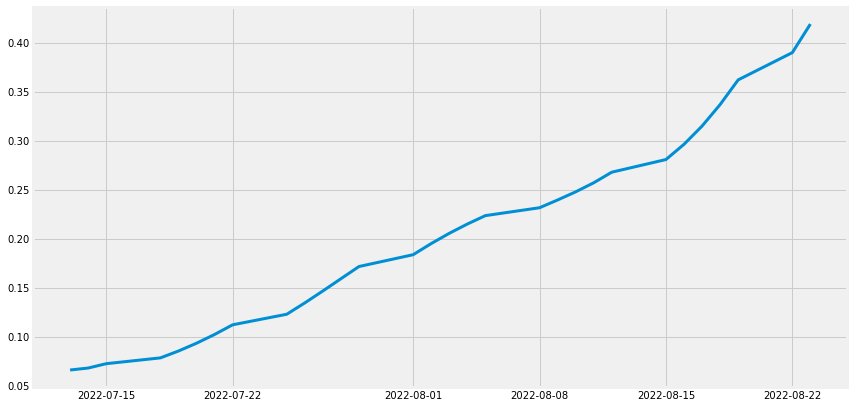

In [69]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

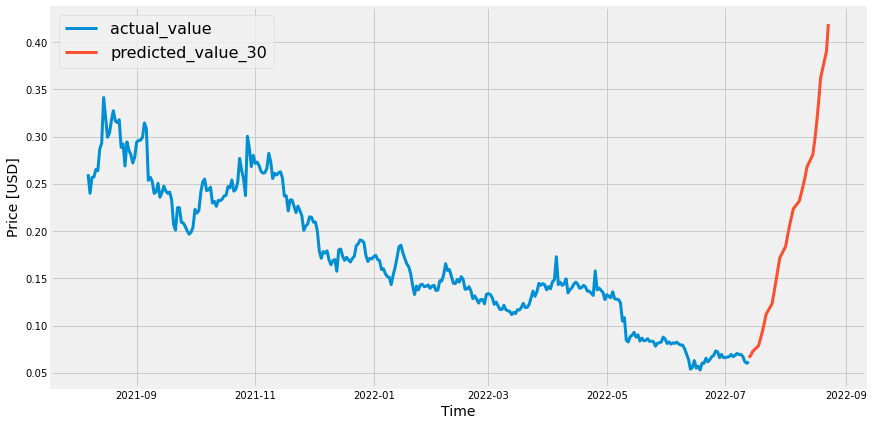

In [70]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)